<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import patsy
from __future__ import division

from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import statsmodels.formula.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/nehemiahloury/anaconda/envs/dsi/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [20]:
business_raw = pd.read_csv('../../DSI-SF-3/datasets/yelp_arizona_data/businesses_small_parsed.csv')

In [21]:
business_raw.drop(['latitude', 'longitude', 'neighborhoods'], axis=1, inplace=True)

In [22]:
business_raw['is_vegas'] = business_raw['city'] == 'Las Vegas'
business_raw['is_vegas'].mean()

0.61386358877721947

In [23]:
business_raw.head()

,business_id,name,review_count,city,stars,categories,variable,value,is_vegas
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",attributes.Ambience.divey,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",attributes.Ambience.divey,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",attributes.Ambience.divey,False,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",attributes.Ambience.divey,False,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",attributes.Ambience.divey,False,False


In [24]:
# Create Wide Dataset
business_wide2 = business_raw.pivot(index='business_id', columns='variable', values='value').reset_index()
business_wide2 = business_wide2.sort_values(by='business_id')


# Replace True False
business_wide2.replace(to_replace=['true', 'false', 'True', 'False'], value=[True, False, True, False], inplace=True)

# Drop Non Dummy columns
business_wide2 = business_wide2.ix[:,(business_wide2.apply(lambda x: len(x.unique())) <= 3) | (business_wide2.columns == 'business_id')]

# Fill NAs with False
business_wide2.ix[:,business_wide2.apply(lambda x: len(x.unique())) <= 3] = business_wide2.ix[:,business_wide2.apply(lambda x: len(x.unique())) <= 3].fillna(False)
business_wide2.shape

(4132, 57)

In [28]:
# Drop Dups
business_wide1 = business_raw.drop(['variable', 'value'], axis=1)
business_wide1.drop_duplicates(inplace=True)

business_wide1 = business_wide1.sort_values(by='business_id').reset_index(drop=True)

In [29]:
# Get Categories
business_wide1['categories'] = business_wide1['categories'].apply(lambda x: x.replace("[", ""))
business_wide1['categories'] = business_wide1['categories'].apply(lambda x: x.replace("]", ""))
business_wide1['categories'] = business_wide1['categories'].apply(lambda x: x.replace("'", ""))
business_wide1['categories'] = business_wide1['categories'].apply(lambda x: x.replace('"', ''))
business_wide1['categories'] = business_wide1['categories'].apply(lambda x: x.split(','))
business_wide1['categories'] = business_wide1['categories'].apply(lambda x: map(lambda y: y.strip(), x))

cat_list = list(business_wide1['categories'])
cat_list = [item for sublist in cat_list for item in sublist]
cat_set = set(cat_list)

# Could have just used eval and iteltools check...FUCK ME
cat_set

{'Active Life',
 'Adult Entertainment',
 'Afghan',
 'Airport Lounges',
 'Airports',
 'Amateur Sports Teams',
 'American (New)',
 'American (Traditional)',
 'Arcades',
 'Art Galleries',
 'Arts & Crafts',
 'Arts & Entertainment',
 'Asian Fusion',
 'Bagels',
 'Bakeries',
 'Barbeque',
 'Barbers',
 'Barre Classes',
 'Bars',
 'Beauty & Spas',
 'Beer',
 'Beer Bar',
 'Beer Gardens',
 'Books',
 'Boot Camps',
 'Botanical Gardens',
 'Bowling',
 'Brasseries',
 'Breakfast & Brunch',
 'Breweries',
 'British',
 'Bubble Tea',
 'Buffets',
 'Burgers',
 'Cabaret',
 'Cafes',
 'Canadian (New)',
 'Candy Stores',
 'Caribbean',
 'Casinos',
 'Caterers',
 'Champagne Bars',
 'Cheesesteaks',
 'Chicken Shop',
 'Chicken Wings',
 'Chinese',
 'Chocolatiers & Shops',
 'Cinema',
 'Cocktail Bars',
 'Coffee & Tea',
 'Comedy Clubs',
 'Comfort Food',
 'Comic Books',
 'Convenience Stores',
 'Cooking Classes',
 'Country Dance Halls',
 'Courthouses',
 'Creperies',
 'Cuban',
 'Cultural Center',
 'Cupcakes',
 'Dance Clubs',
 'D

In [31]:
cat_list = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

for cat in cat_list:
    business_wide1[cat] = business_wide1['categories'].apply(lambda x: cat in x)

In [34]:
business_wide1

Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'is_vegas', u'Airports', u'Breakfast & Brunch',
       u'Bubble Tea', u'Burgers', u'Bars', u'Bakeries', u'Breweries', u'Cafes',
       u'Candy Stores', u'Comedy Clubs', u'Courthouses', u'Dance Clubs',
       u'Fast Food', u'Museums', u'Tattoo', u'Vape Shops', u'Yoga'],
      dtype='object')

In [15]:
# Make Dummy Category Columns
# for cat in cat_set:
#    business_wide1[cat] = business_wide1['categories'].apply(lambda x: cat in x)

# business_wide1.head()

,business_id,name,review_count,city,stars,categories,is_vegas,Drugstores,Tapas/Small Plates,Afghan,...,Chocolatiers & Shops,American (Traditional),Barre Classes,Meat Shops,Japanese,Arcades,Specialty Food,Gift Shops,Cabaret,Soul Food
0,--jFTZmywe7StuZ2hEjxyA,Subway,7,Las Vegas,3.5,"[Fast Food, Sandwiches, Restaurants]",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0HGqwlfw3I8nkJyMHxAsQ,McDonald's,9,Phoenix,3.0,"[Burgers, Fast Food, Restaurants]",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0VK5Z1BfUHUYq4PoBYNLw,T Spot,5,Las Vegas,3.5,"[Bars, Nightlife, Lounges]",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0bUDim5OGuv8R0Qqq6J4A,IHOP,8,Phoenix,2.0,"[Bakeries, Food, Breakfast & Brunch, Restaurants]",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1bOb2izeJBZjHC7NWxiPA,First Watch,120,Phoenix,4.0,"[Breakfast & Brunch, Cafes, American (Traditio...",False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [16]:
business_wide1_num = business_wide1.select_dtypes(exclude=['object'])
business_wide1_num = business_wide1_num.ix[:,business_wide1_num.sum() != 0]
business_wide1_num.shape

(4132, 217)

In [17]:
business = pd.merge(business_wide1, business_wide2, on='business_id', how='outer')
business.shape

(4132, 277)

In [18]:
business_num = business.select_dtypes(exclude=['object'])
business_num = business_num.ix[:,business_num.sum() != 0]
business_num.shape

(4132, 268)

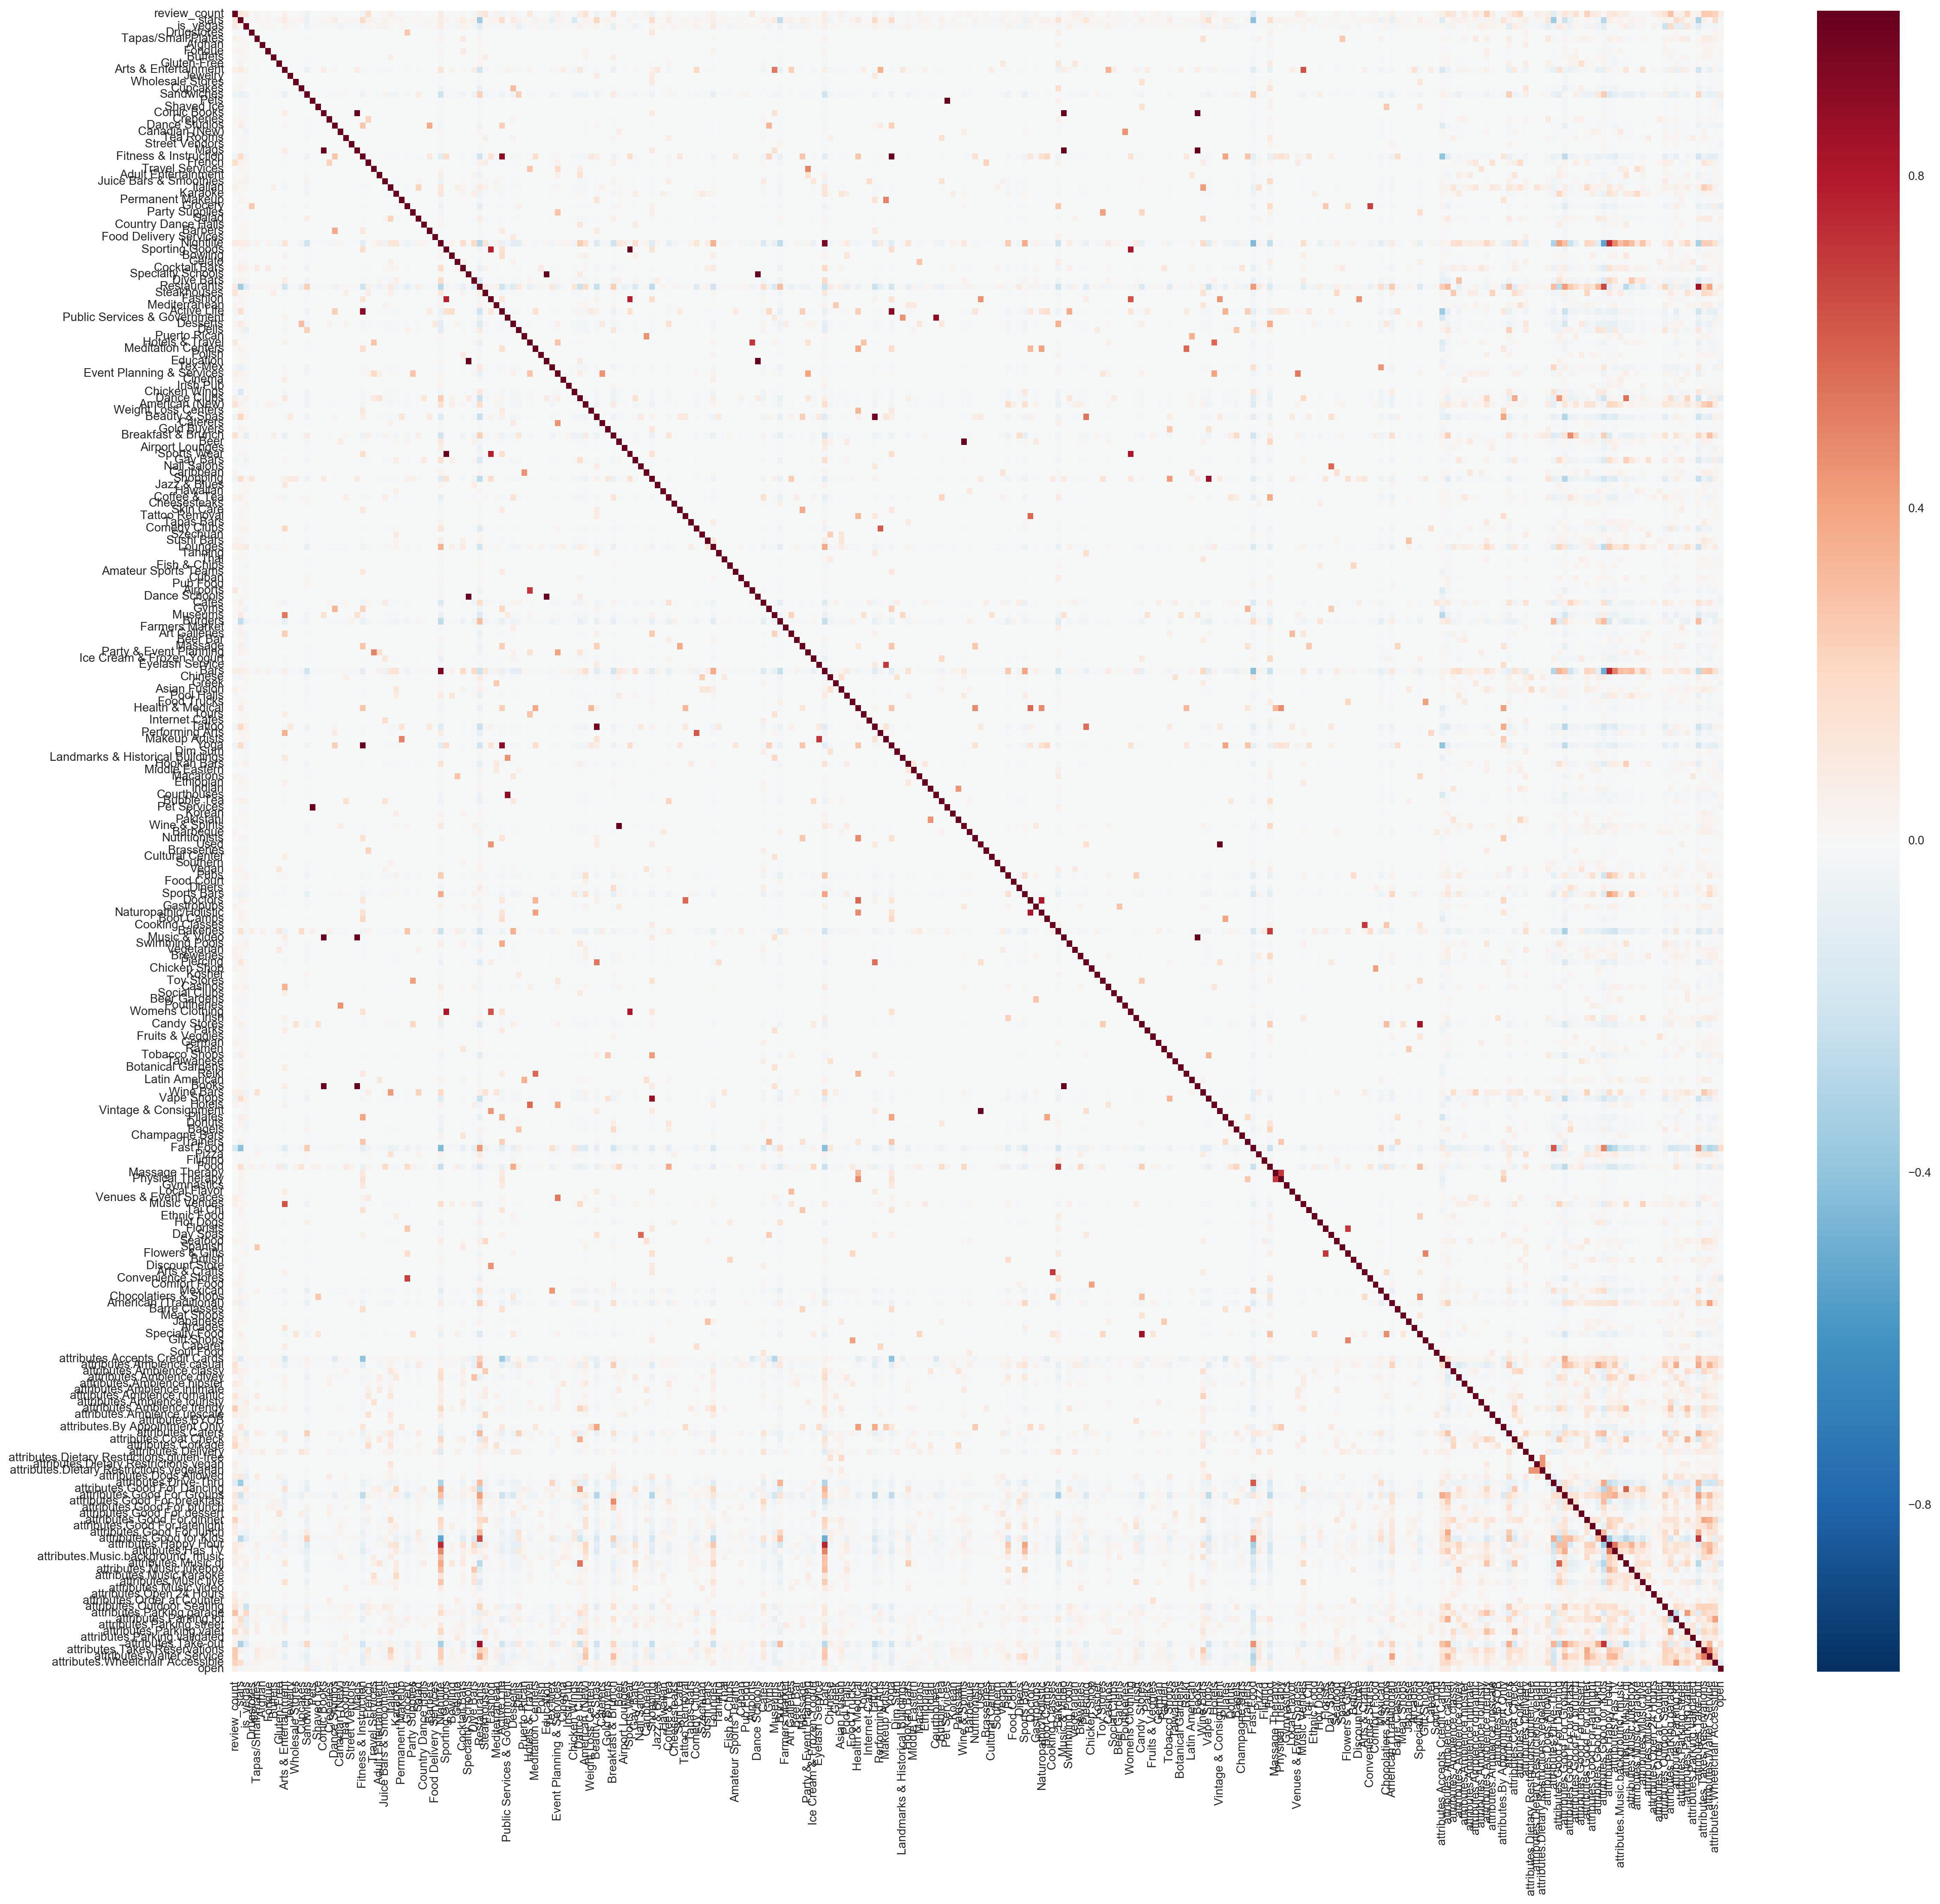

In [19]:
#Heat Map
b_corr = business_num.corr()
plt.figure(figsize=(25,25))
sns.heatmap(b_corr)

In [231]:
# Split up in predictor and Target (All Variables)
y = business_num['is_vegas']
X = business_num.drop('is_vegas', axis=1)

# Normalize
ss = StandardScaler()
Xn = ss.fit_transform(X)

# Predictor (just catagories)
X_cat = business_wide1_num.drop('is_vegas', axis=1)

# Normalize
Xn_cat = ss.fit_transform(X_cat)

In [232]:
# KNN
for i in range(10, 30, 2):
    KNN = KNeighborsClassifier(n_neighbors=i, weights='distance')
    print 'Number of Neighbors: ', i
    print cross_val_score(KNN, Xn, y, cv=5)

Number of Neighbors:  10
[ 0.64087062  0.62998791  0.64891041  0.6464891   0.63075061]
Number of Neighbors:  12
[ 0.64570738  0.62636034  0.6464891   0.64527845  0.62590799]
Number of Neighbors:  14
[ 0.63845224  0.62756953  0.65254237  0.64769976  0.62953995]
Number of Neighbors:  16
[ 0.643289    0.62636034  0.6598063   0.64285714  0.64769976]
Number of Neighbors:  18
[ 0.64570738  0.63361548  0.67070218  0.64043584  0.63438257]
Number of Neighbors:  20
[ 0.64207981  0.62877872  0.66343826  0.64043584  0.62711864]
Number of Neighbors:  22
[ 0.643289    0.6311971   0.65738499  0.64043584  0.62953995]
Number of Neighbors:  24
[ 0.64933495  0.62877872  0.65859564  0.65133172  0.63075061]
Number of Neighbors:  26
[ 0.64812576  0.62031439  0.64527845  0.64769976  0.63317191]
Number of Neighbors:  28
[ 0.643289    0.62756953  0.65012107  0.65012107  0.62227603]


In [233]:
# KNN (only categories)
for i in range(10, 30, 2):
    KNN = KNeighborsClassifier(n_neighbors=i, weights='distance')
    print 'Number of Neighbors: ', i
    print cross_val_score(KNN, Xn_cat, y, cv=5)

Number of Neighbors:  10
[ 0.61305925  0.60338573  0.62106538  0.60895884  0.5968523 ]
Number of Neighbors:  12
[ 0.61064087  0.60459492  0.62953995  0.60532688  0.59443099]
Number of Neighbors:  14
[ 0.60338573  0.61185006  0.61985472  0.60411622  0.59322034]
Number of Neighbors:  16
[ 0.61426844  0.61064087  0.62227603  0.60653753  0.59322034]
Number of Neighbors:  18
[ 0.61185006  0.60822249  0.62590799  0.61622276  0.59200969]
Number of Neighbors:  20
[ 0.6070133   0.60822249  0.62590799  0.61501211  0.59564165]
Number of Neighbors:  22
[ 0.60822249  0.60338573  0.62711864  0.61622276  0.60169492]
Number of Neighbors:  24
[ 0.61305925  0.61305925  0.62711864  0.61622276  0.59564165]
Number of Neighbors:  26
[ 0.61185006  0.6070133   0.62469734  0.61622276  0.59927361]
Number of Neighbors:  28
[ 0.61185006  0.60217654  0.62469734  0.61985472  0.59806295]


In [243]:
# Ridge Regularization
alphas = np.logspace(-4,5,num=50)
logreg_ridge = LogisticRegressionCV(Cs = alphas, cv=5, penalty='l2')
logreg_ridge.fit(Xn, y)

LogisticRegressionCV(Cs=array([  1.00000e-04,   1.52642e-04,   2.32995e-04,   3.55648e-04,
         5.42868e-04,   8.28643e-04,   1.26486e-03,   1.93070e-03,
         2.94705e-03,   4.49843e-03,   6.86649e-03,   1.04811e-02,
         1.59986e-02,   2.44205e-02,   3.72759e-02,   5.68987e-02,
         8.68511e-02,   1.325...     1.20679e+04,   1.84207e+04,   2.81177e+04,   4.29193e+04,
         6.55129e+04,   1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [270]:
# Ridge Accuracy
print 'Baseline: ', business_raw['is_vegas'].mean()
print 'Accuracy: ', logreg_ridge.score(Xn, y)

Baseline:  0.613863588777
Accuracy:  0.715634075508


In [255]:
# Ridge Confusion Matrix
ridge_pred = logreg_ridge.predict(Xn)
confusion_matrix(y, ridge_pred)

array([[ 749,  813],
       [ 362, 2208]])

In [259]:
# Ridge Classification Report
print classification_report(y, ridge_pred)

             precision    recall  f1-score   support

      False       0.67      0.48      0.56      1562
       True       0.73      0.86      0.79      2570

avg / total       0.71      0.72      0.70      4132



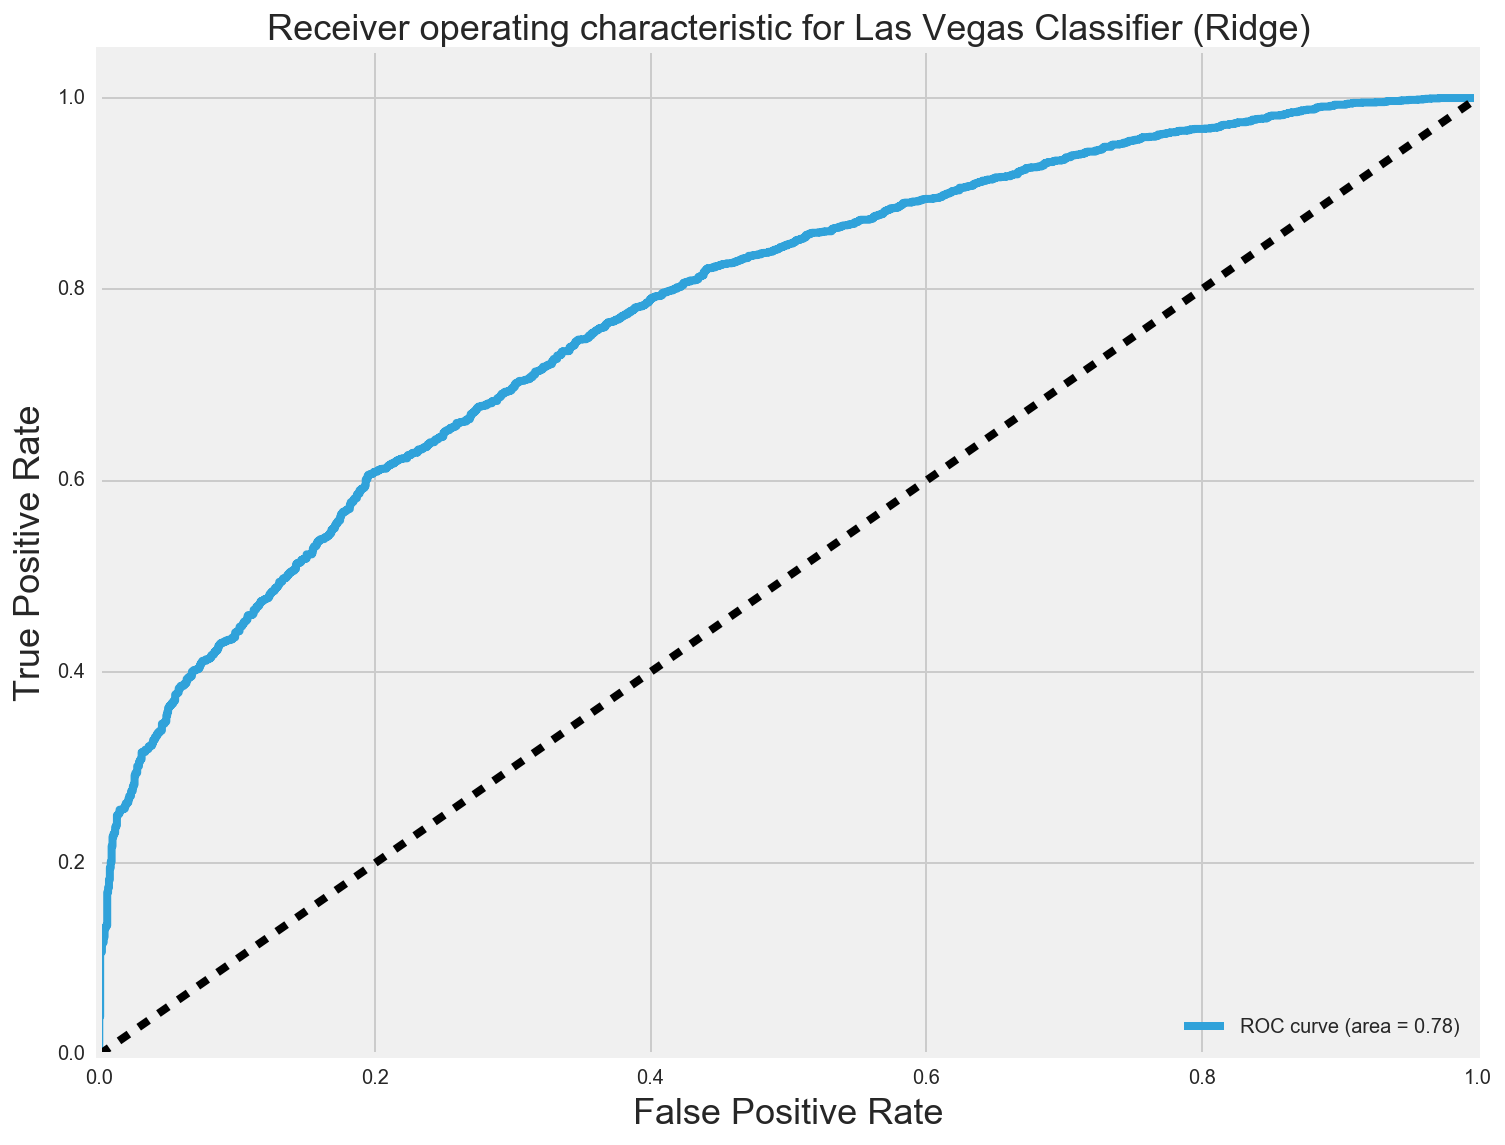

In [266]:
# Ridge ROC Curve
y_score = logreg_ridge.decision_function(Xn)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (is_vegas)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Las Vegas Classifier (Ridge)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [252]:
# Lasso Regularization
alphas = np.logspace(-4,5,num=50)
logreg_lasso = LogisticRegressionCV(Cs = alphas, cv=5, penalty='l1', solver = 'liblinear')
logreg_lasso.fit(Xn, y)

LogisticRegressionCV(Cs=array([  1.00000e-04,   1.52642e-04,   2.32995e-04,   3.55648e-04,
         5.42868e-04,   8.28643e-04,   1.26486e-03,   1.93070e-03,
         2.94705e-03,   4.49843e-03,   6.86649e-03,   1.04811e-02,
         1.59986e-02,   2.44205e-02,   3.72759e-02,   5.68987e-02,
         8.68511e-02,   1.325...     1.20679e+04,   1.84207e+04,   2.81177e+04,   4.29193e+04,
         6.55129e+04,   1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [269]:
# Lasso Accuracy
print 'Baseline: ', business_raw['is_vegas'].mean()
print 'Accuracy: ', logreg_lasso.score(Xn, y)

Baseline:  0.613863588777
Accuracy:  0.715392061955


In [261]:
# Lasso Confusion Matrix
lasso_pred = logreg_lasso.predict_proba()
confusion_matrix(y, lasso_pred)

array([[ 772,  790],
       [ 386, 2184]])

In [262]:
# Lasso Classification Report
print classification_report(y, lasso_pred)

             precision    recall  f1-score   support

      False       0.67      0.49      0.57      1562
       True       0.73      0.85      0.79      2570

avg / total       0.71      0.72      0.70      4132



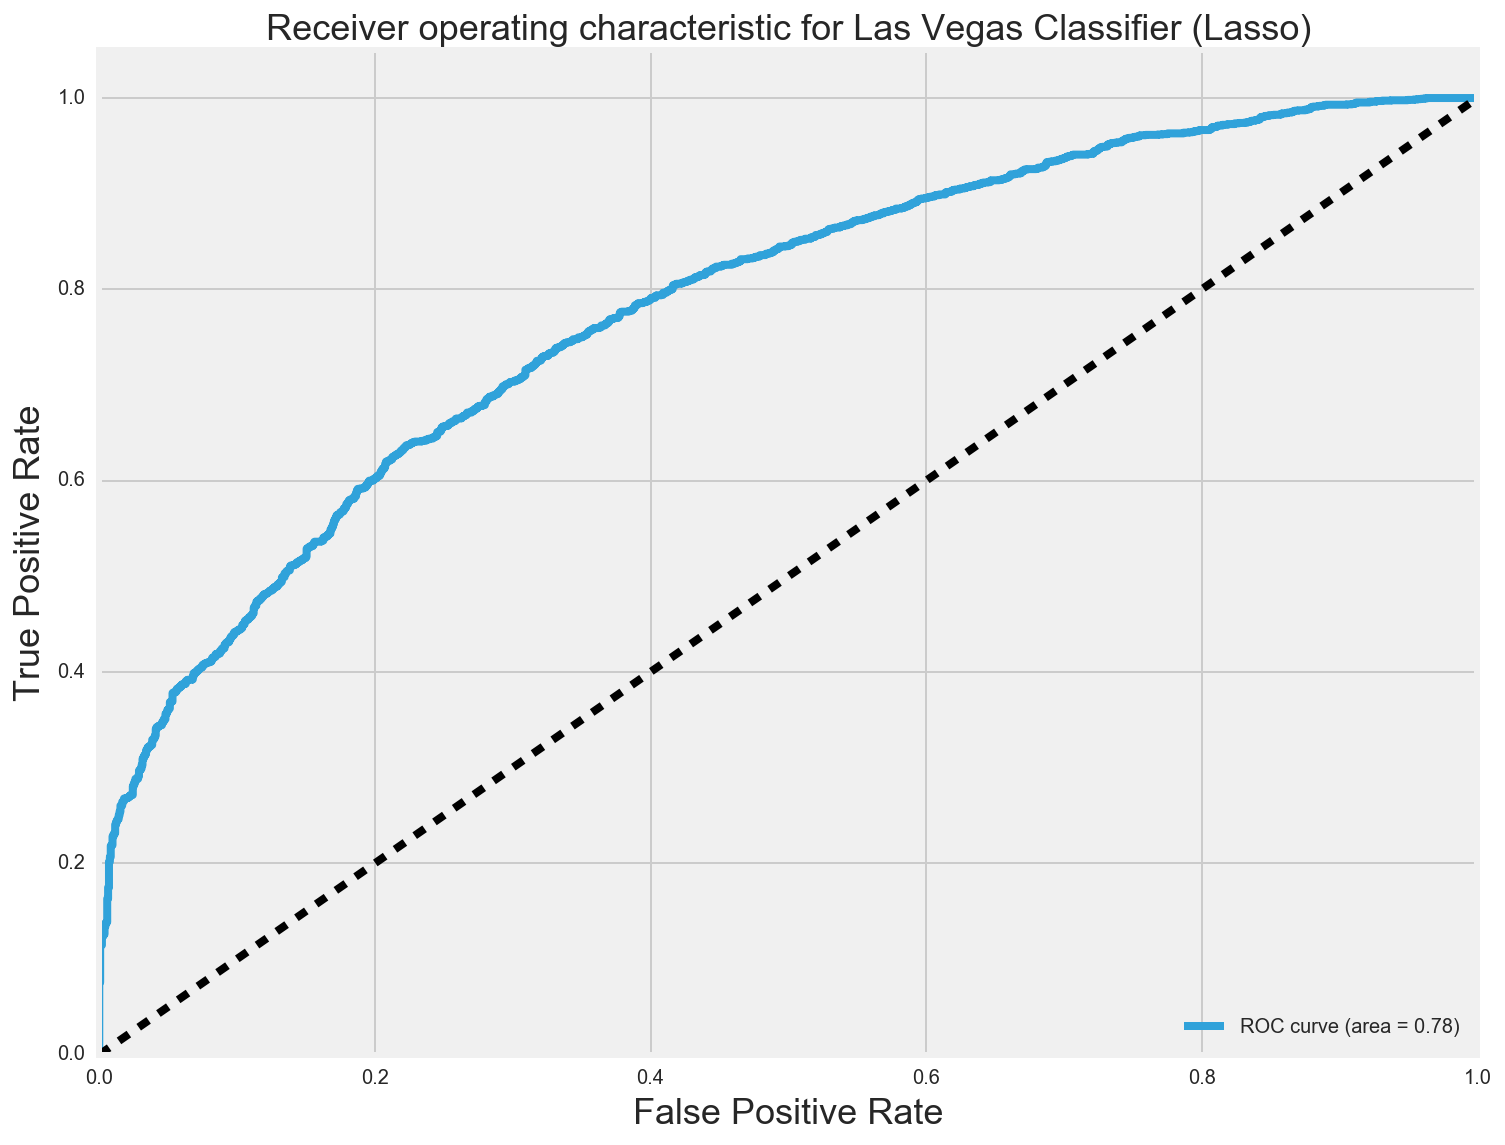

In [267]:
# Lasso ROC Curve
lasso_y_score = logreg_lasso.decision_function(Xn)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y, lasso_y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (is_vegas)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Las Vegas Classifier (Lasso)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [295]:
# Ridge Coefficients
ridge_coefs = pd.Series(list(logreg_ridge.coef_.reshape(-1,1)))
ridge_coefs = ridge_coefs.apply(lambda x: x[0])
names = pd.Series(X.columns)
ridge_coefs = pd.concat([names, ridge_coefs], axis=1)
ridge_coefs.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)
ridge_coefs.sort_values(by='Coefficient', ascending=False, inplace=True)
print ridge_coefs.nlargest(10, ['Coefficient'])
print ridge_coefs.nsmallest(10, ['Coefficient'])

                           Feature  Coefficient
257      attributes.Parking.garage     0.445801
0                     review_count     0.328750
238     attributes.Good For Groups     0.279946
177                        Pilates     0.237789
149                 Swimming Pools     0.189995
156                        Casinos     0.174944
240     attributes.Good For.brunch     0.157545
237    attributes.Good For Dancing     0.140794
25             Adult Entertainment     0.135858
243  attributes.Good For.latenight     0.124720
                        Feature  Coefficient
256  attributes.Outdoor Seating    -0.448121
43                  Restaurants    -0.210253
259   attributes.Parking.street    -0.183552
67           Breakfast & Brunch    -0.160476
242  attributes.Good For.dinner    -0.150296
95                         Gyms    -0.135922
147                    Bakeries    -0.132075
18               Canadian (New)    -0.118620
228           attributes.Caters    -0.117995
99                Art 

### Answers with the class

### Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

From looking at the coefficient from my ridge logistic regression on yelp business features, we can see a number of features that either suggest a business is in Las Vegas or suggest that it is not. Many of these intuitively make sense given what types of businesses Las Vegas is typically associated with.

Features that increase likelihood of being in Las Vegas:
- Having a parking parage
- Number of reviews
- Being good for groups
- Offering pilates
- Having a swimming pool
- Being a casino


Features that decrease likelihood of being in Las Vegas:
- Having outdoor seating
- Being a restaurant
- Having street parking
- Having breakfast/brunch
- Being good for dinner
- Being a gym

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

### Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.

In [514]:
# Read in Data
reviews = pd.read_csv('../../yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('../../yelp_arizona_data/tips_small_nlp_parsed.csv')

In [44]:
# Get Service Column Names
service_review_mask = ['service' in x for x in reviews.columns]
staff_review_mask = ['staff' in x for x in reviews.columns]
service_tips_mask = ['service' in x for x in tips.columns]
staff_tips_mask = ['staff' in x for x in tips.columns]
reviews_service_columns = list(pd.Series(reviews.columns)[staff_review_mask])
tips_service_columns = list(pd.Series(tips.columns)[staff_tips_mask])
reviews_service_columns += list(pd.Series(reviews.columns)[service_review_mask])
tips_service_columns += list(pd.Series(tips.columns)[service_tips_mask])


In [66]:
# Create Service Focused Columns
tips['num_service_reference'] = tips[tips_service_columns].apply(sum, axis=1)
reviews['num_service_reference'] = reviews[reviews_service_columns].apply(sum, axis=1)
tips['service_review'] = tips['num_service_reference'] > 0
reviews['service_review'] = reviews['num_service_reference'] > 0

In [95]:
# Calculate Number of Service References Per Review/Tip By User
rev_service_ref_user = reviews.groupby('user_id')['num_service_reference'].agg(lambda x: sum(x)/len(x)).reset_index()
tip_service_ref_user = tips.groupby('user_id')['num_service_reference'].agg(lambda x: sum(x)/len(x)).reset_index()

(0, 5, 0, 25000)

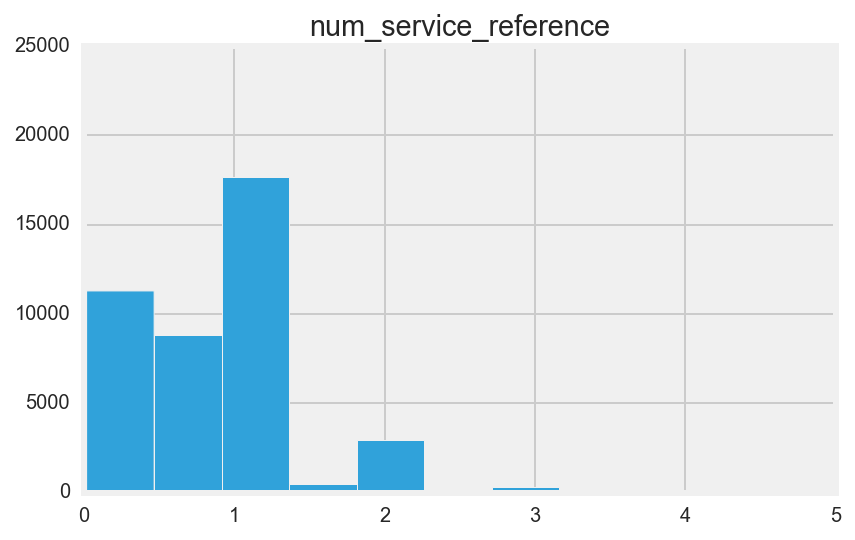

In [117]:
# Service References Per Review By User Histogram (References > 0)
rev_service_ref_user[rev_service_ref_user['num_service_reference'] > 0].hist(bins=20)
plt.axis((0,5,0,25000))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129f2df50>]], dtype=object)

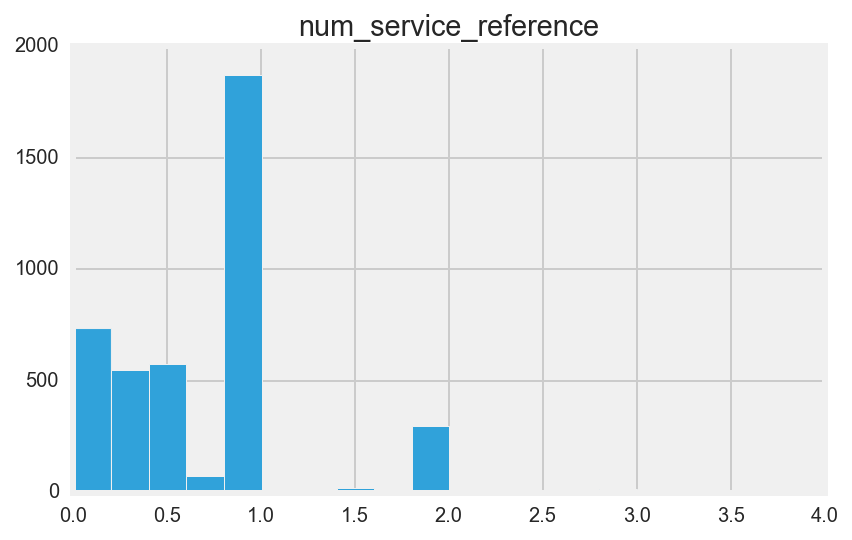

In [120]:
# Service References Per Tip By User Histogram (References > 0)
tip_service_ref_user[tip_service_ref_user['num_service_reference'] > 0].hist(bins=20)

### Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.

In [296]:
biz_reviews = reviews.pivot_table(values='stars', index='business_id', columns='service_review', aggfunc='mean').reset_index()
biz_reviews.rename(columns={'service_review': 'Index', False: 'non_service', True: 'service'}, inplace=True)
biz_reviews.shape

(4132, 3)

### Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). Validate the performance of the models.

In [330]:
# Combine Reviews with business dataset
business_reviews = pd.merge(business, biz_reviews, on='business_id', how='outer')

# Drop null service ratings
business_reviews = business_reviews[~business_reviews['service'].isnull()]
business_reviews = business_reviews[~business_reviews['non_service'].isnull()]

In [356]:
# Create service and non service targets
y_serv = business_reviews['service']
y_non_serv = business_reviews['non_service']

# Create Predictor
X_serv = business_reviews.drop(['stars', 'service', 'non_service'], axis=1).select_dtypes(exclude=['object'])
Xn_serv = ss.fit_transform(X_serv)

In [357]:
y_non_serv.isnull().sum()

0

In [358]:
# Create Models
ridge_alphas = np.logspace(-4,5,num=50)
lr_ridge_serv = RidgeCV(alphas=ridge_alphas, cv=5)
lr_ridge_nonserv = RidgeCV(alphas=ridge_alphas, cv=5)
lr_lasso_serv = LassoCV(alphas=ridge_alphas, cv=5)
lr_lasso_nonserv = RidgeCV(alphas=ridge_alphas, cv=5)

In [359]:
# Service Regression
lr_ridge_serv.fit(Xn_serv, y_serv)

RidgeCV(alphas=array([  1.00000e-04,   1.52642e-04,   2.32995e-04,   3.55648e-04,
         5.42868e-04,   8.28643e-04,   1.26486e-03,   1.93070e-03,
         2.94705e-03,   4.49843e-03,   6.86649e-03,   1.04811e-02,
         1.59986e-02,   2.44205e-02,   3.72759e-02,   5.68987e-02,
         8.68511e-02,   1...     1.20679e+04,   1.84207e+04,   2.81177e+04,   4.29193e+04,
         6.55129e+04,   1.00000e+05]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [360]:
# Service R^2
lr_ridge_serv.score(Xn_serv, y_serv)

0.17733245452327029

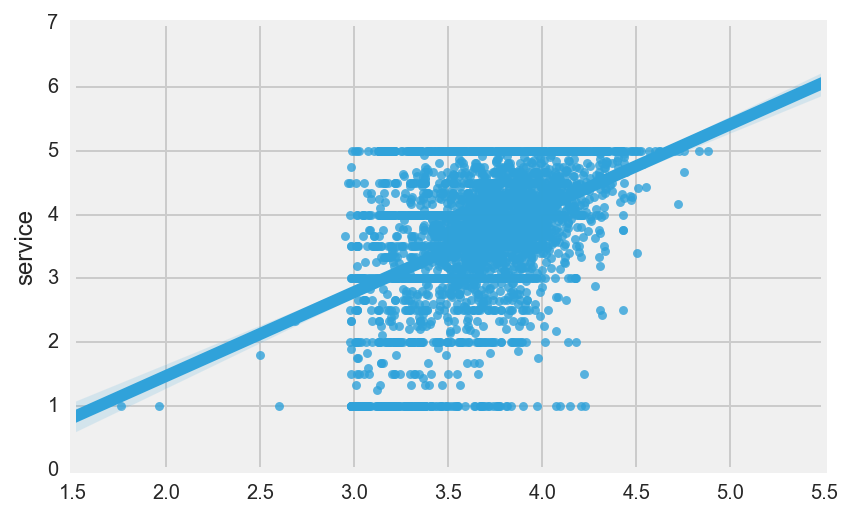

In [361]:
# Plot Service Results
y_pred_serv = lr_ridge_serv.predict(Xn_serv)
sns.regplot(y_pred_serv, y_serv)

In [362]:
# Nonservice Regression
lr_ridge_nonserv.fit(Xn_serv, y_non_serv)

RidgeCV(alphas=array([  1.00000e-04,   1.52642e-04,   2.32995e-04,   3.55648e-04,
         5.42868e-04,   8.28643e-04,   1.26486e-03,   1.93070e-03,
         2.94705e-03,   4.49843e-03,   6.86649e-03,   1.04811e-02,
         1.59986e-02,   2.44205e-02,   3.72759e-02,   5.68987e-02,
         8.68511e-02,   1...     1.20679e+04,   1.84207e+04,   2.81177e+04,   4.29193e+04,
         6.55129e+04,   1.00000e+05]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [365]:
# Nonservice R^2
lr_ridge_nonserv.score(Xn_serv, y_non_serv)

0.38077606065891079

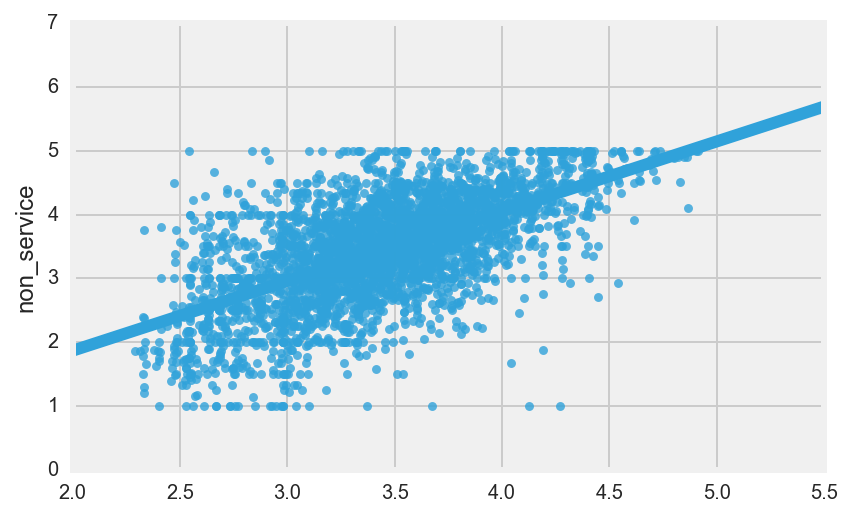

In [366]:
# Plot Non-Service Results
y_pred_non_serv = lr_ridge_nonserv.predict(Xn_serv)
sns.regplot(y_pred_non_serv, y_non_serv)

### Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [370]:
# Ridge Serve Coefficients
serve_coefs = pd.Series(lr_ridge_serv.coef_)
names = pd.Series(X_serv.columns)
serve_coefs = pd.concat([names, serve_coefs], axis=1)
serve_coefs.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)
serve_coefs.sort_values(by='Coefficient', ascending=False, inplace=True)
print serve_coefs.nlargest(10, 'Coefficient')
print serve_coefs.nsmallest(10, 'Coefficient')

                        Feature  Coefficient
263      attributes.Parking.lot     0.060969
174                  Vape Shops     0.056696
218  attributes.Ambience.casual     0.036816
74                     Shopping     0.035148
120                 Hookah Bars     0.032822
96                      Museums     0.027259
0                  review_count     0.026910
94                        Cafes     0.026410
232         attributes.Delivery     0.026214
261  attributes.Outdoor Seating     0.025891
                             Feature  Coefficient
182                        Fast Food    -0.059650
241            attributes.Drive-Thru    -0.053098
43                       Restaurants    -0.051635
97                           Burgers    -0.041941
267              attributes.Take-out    -0.034245
139                       Food Court    -0.024785
60                     Chicken Wings    -0.024767
141                      Sports Bars    -0.022120
250         attributes.Good for Kids    -0.021592
216  

In [371]:
# Ridge Nonerve Coefficients
non_serve_coefs = pd.Series(lr_ridge_nonserv.coef_)
non_serve_coefs = pd.concat([names, non_serve_coefs], axis=1)
non_serve_coefs.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)
non_serve_coefs.sort_values(by='Coefficient', ascending=False, inplace=True)
print non_serve_coefs.nlargest(10, 'Coefficient')
print non_serve_coefs.nsmallest(10, 'Coefficient')

                              Feature  Coefficient
174                        Vape Shops     0.072981
263            attributes.Parking.lot     0.071597
0                        review_count     0.060359
114                            Tattoo     0.049474
64                      Beauty & Spas     0.045444
249         attributes.Good For.lunch     0.044861
270  attributes.Wheelchair Accessible     0.044810
218        attributes.Ambience.casual     0.040405
102            Party & Event Planning     0.039631
212                    Specialty Food     0.035871
                   Feature  Coefficient
182              Fast Food    -0.104484
43             Restaurants    -0.094681
241  attributes.Drive-Thru    -0.076487
60           Chicken Wings    -0.058629
97                 Burgers    -0.051285
267    attributes.Take-out    -0.046412
30                 Grocery    -0.039352
254    attributes.Music.dj    -0.037694
61             Dance Clubs    -0.036565
141            Sports Bars    -0.034894

There are some difference aomngst the model coefficient. Mostly we see categories in the non-service model that are not directly related to food (i.e. Tattoo, and Beauty & Spa). This makes intuitive sense because people are less likely to be mentioning service in their reviews of those types of business so they would likely only have an effect on non_service ratings. However, the features that negatively correlate with service or non service ratings tend to be similar across both categories (Fast Food, Drive Through, Restaurants, etc.)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"

### Build the Model

In [599]:
# Import Data
users = pd.read_csv('../../yelp_arizona_data/users_small_parsed.csv')

In [600]:
print users.shape
print users.columns

(144206, 21)
Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


In [601]:
# Add Year variables
users['yelping_since'] = pd.to_datetime(users['yelping_since'])
users['yr_joined'] = users['yelping_since'].dt.year
users['yrs_member'] = 2016 - users['yr_joined']

In [602]:
# Change elite to list
users['elite'] = users['elite'].apply(lambda x: x.replace("[", ""))
users['elite'] = users['elite'].apply(lambda x: x.replace("]", ""))
users['elite'] = users['elite'].apply(lambda x: x.split(","))
users['elite'] = users['elite'].apply(lambda x: map(lambda y: y.strip(), x))

In [603]:
# Create is_elite classifier if user is elite for >= 50% of year they have been a user
from __future__ import division
users['is_elite'] = (users['elite'].apply(lambda x: len(x)) / users['yrs_member']) >= .5

In [604]:
users['is_elite'].value_counts()

False    105797
True      38409
Name: is_elite, dtype: int64

In [605]:
# Fill compliments columns with zeros
users.fillna(value=0 ,inplace=True)

In [606]:
# Create target and predictor
y_elite = users['is_elite']

users_num = users.select_dtypes(exclude=['object', 'datetime'])
users_num.drop(['yr_joined', 'is_elite'], axis=1, inplace=True)
comp_cols = [s for s in list(users_num.columns) if 'compliments' in s]
users_num_no_comp = users_num.drop(comp_cols, axis=1)

ss = StandardScaler()
Xn_elite = ss.fit_transform(users_num)
Xn_elite_nocomp = ss.fit_transform(users_num_no_comp)

/Users/nehemiahloury/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [649]:
# Make Full Regression
Xn_elite_train, Xn_elite_test, y_elite_train, y_elite_test = train_test_split(Xn_elite, y_elite)
alphas = np.logspace(-4,5,num=50)
logreg_ridge_elite = LogisticRegressionCV(Cs = alphas, cv=5, penalty='l2')
logreg_ridge_elite.fit(Xn_elite_train, y_elite_train)

LogisticRegressionCV(Cs=array([  1.00000e-04,   1.52642e-04,   2.32995e-04,   3.55648e-04,
         5.42868e-04,   8.28643e-04,   1.26486e-03,   1.93070e-03,
         2.94705e-03,   4.49843e-03,   6.86649e-03,   1.04811e-02,
         1.59986e-02,   2.44205e-02,   3.72759e-02,   5.68987e-02,
         8.68511e-02,   1.325...     1.20679e+04,   1.84207e+04,   2.81177e+04,   4.29193e+04,
         6.55129e+04,   1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [650]:
# Ridge Accuracy
print 'Baseline: ', 1 - y_elite.mean()
print 'Accuracy: ', logreg_ridge_elite.score(Xn_elite_test, y_elite_test)

Baseline:  0.733651859146
Accuracy:  0.957200710085


In [651]:
# Ridge Confusion Matrix
ridge_pred_elite = logreg_ridge_elite.predict(Xn_elite_test)
confusion_matrix(y_elite_test, ridge_pred_elite)

array([[26082,   449],
       [ 1094,  8427]])

In [652]:
# Classification Report
print classification_report(y_elite_test, ridge_pred_elite)

             precision    recall  f1-score   support

      False       0.96      0.98      0.97     26531
       True       0.95      0.89      0.92      9521

avg / total       0.96      0.96      0.96     36052



### What things predict well whether a user is elite or not?

In [653]:
# Ridge Elite Coefficients
elite_coefs = pd.Series(logreg_ridge_elite.coef_.reshape(-1))
names = pd.Series(users_num.columns)
elite_coefs = pd.concat([names, elite_coefs], axis=1)
elite_coefs.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)
elite_coefs.sort_values(by='Coefficient', ascending=False, inplace=True)
print elite_coefs.nlargest(5, 'Coefficient')
print elite_coefs.nsmallest(5, 'Coefficient')

               Feature  Coefficient
1         review_count     1.257466
4                 fans     0.473682
16        votes.useful     0.338585
3   compliments.writer     0.153649
7     compliments.cool     0.090747
                Feature  Coefficient
17           yrs_member    -2.357872
14   compliments.photos    -0.152709
15    compliments.funny    -0.109589
8   compliments.profile    -0.082099
13          votes.funny    -0.044039


### If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.

In [630]:
# Drop Counts
users_no_counts = users_num[['average_stars', 'yrs_member']]
Xn_no_counts = ss.fit_transform(users_no_counts)

In [641]:
# Make no counts regression
Xn_no_counts_train, Xn_no_counts_test, y_elite_train_nc, y_elite_test_nc = train_test_split(Xn_no_counts, y_elite)
alphas = np.logspace(-4,5,num=50)
logreg_ridge_count = LogisticRegressionCV(Cs = alphas, cv=5, penalty='l2')
logreg_ridge_count.fit(Xn_no_counts_train, y_elite_train_nc)

LogisticRegressionCV(Cs=array([  1.00000e-04,   1.52642e-04,   2.32995e-04,   3.55648e-04,
         5.42868e-04,   8.28643e-04,   1.26486e-03,   1.93070e-03,
         2.94705e-03,   4.49843e-03,   6.86649e-03,   1.04811e-02,
         1.59986e-02,   2.44205e-02,   3.72759e-02,   5.68987e-02,
         8.68511e-02,   1.325...     1.20679e+04,   1.84207e+04,   2.81177e+04,   4.29193e+04,
         6.55129e+04,   1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [642]:
# Ridge Accuracy
print 'Baseline: ', 1 - y_elite.mean()
print 'Accuracy: ', logreg_ridge_count.score(Xn_no_counts_test, y_elite_test_nc)

Baseline:  0.733651859146
Accuracy:  0.944053034506


In [643]:
# Ridge Confusion Matrix
ridge_pred_elite = logreg_ridge_count.predict(Xn_no_counts_test)
confusion_matrix(y_elite_test, ridge_pred_elite)

array([[20977,  5541],
       [ 7586,  1948]])

In [644]:
# Classification Report
print classification_report(y_elite_test_nc, ridge_pred_elite)

             precision    recall  f1-score   support

      False       0.93      1.00      0.96     26546
       True       1.00      0.79      0.88      9506

avg / total       0.95      0.94      0.94     36052



In [645]:
# Ridge No Count Coefficients
elite_coefs_count = pd.Series(logreg_ridge_count.coef_.reshape(-1))
names = pd.Series(users_no_counts.columns)
elite_coefs_count = pd.concat([names, elite_coefs_count], axis=1)
elite_coefs_count.rename(columns={0: 'Feature', 1: 'Coefficient'}, inplace=True)
elite_coefs_count.sort_values(by='Coefficient', ascending=False, inplace=True)
elite_coefs_count

,Feature,Coefficient
0,average_stars,0.012899
1,yrs_member,-1.363608


### Think of a way to visually represent your results in a compelling way.

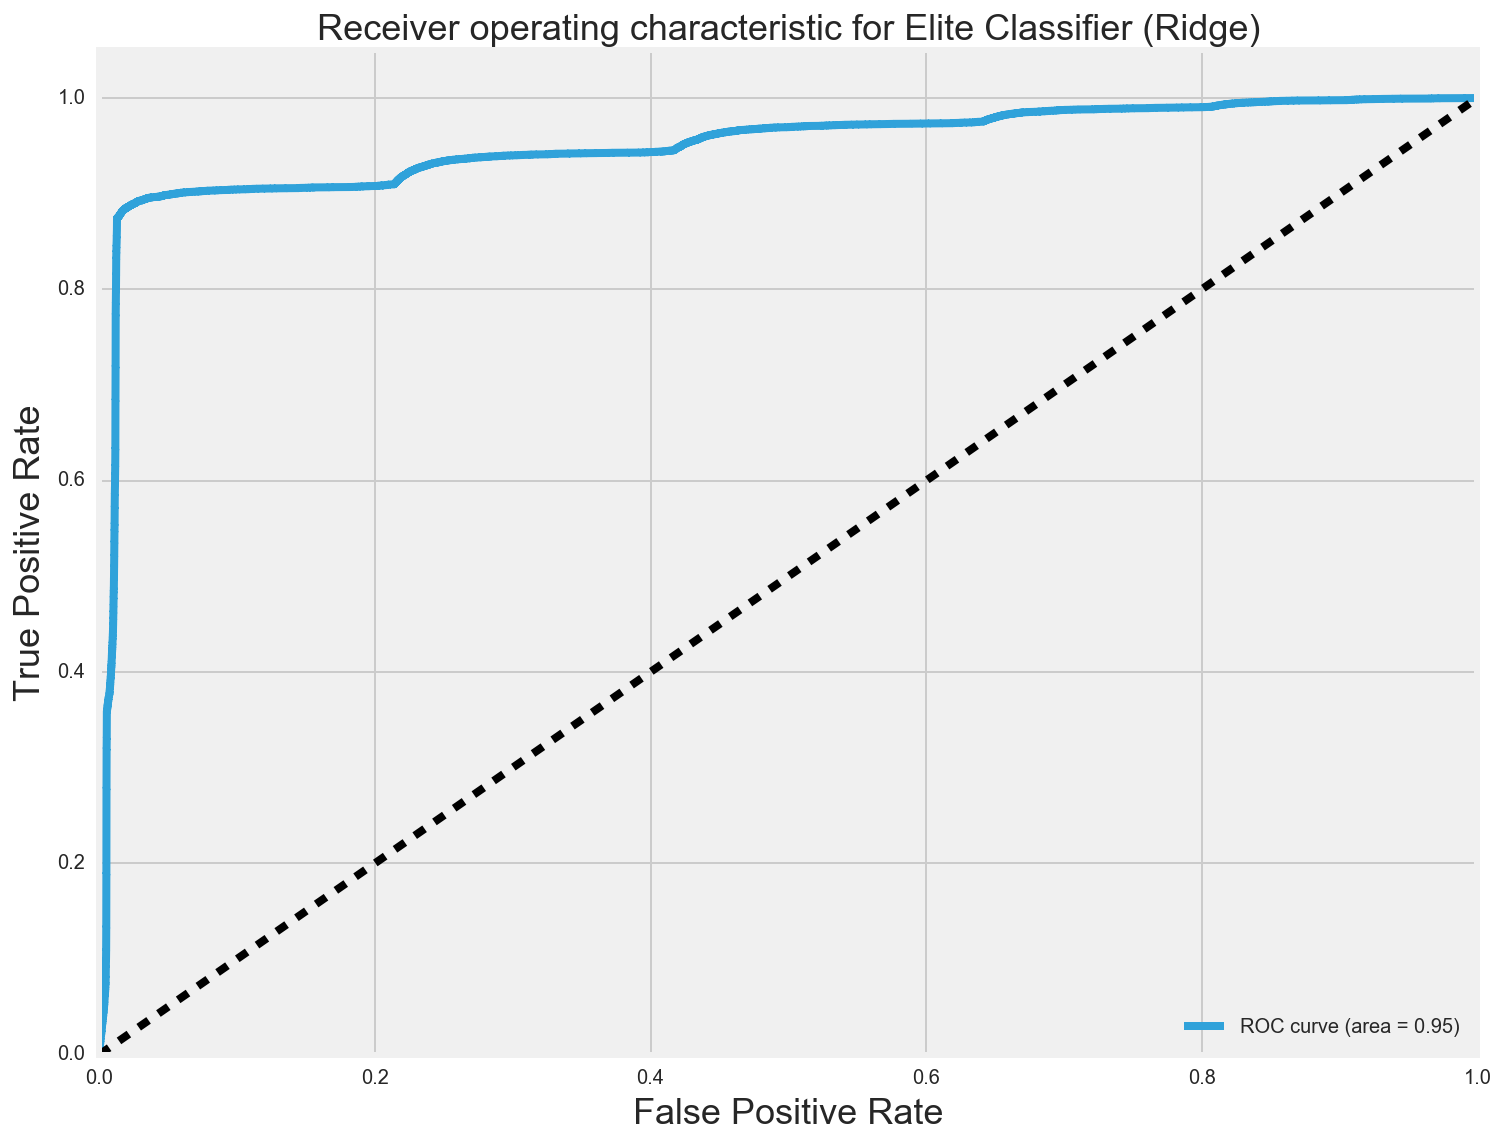

In [655]:
# Ridge ROC Curve
ridge_elite_y_score = logreg_ridge_elite.decision_function(Xn_elite_train)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_elite_train, ridge_elite_y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (is_elite)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Elite Classifier (Ridge)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

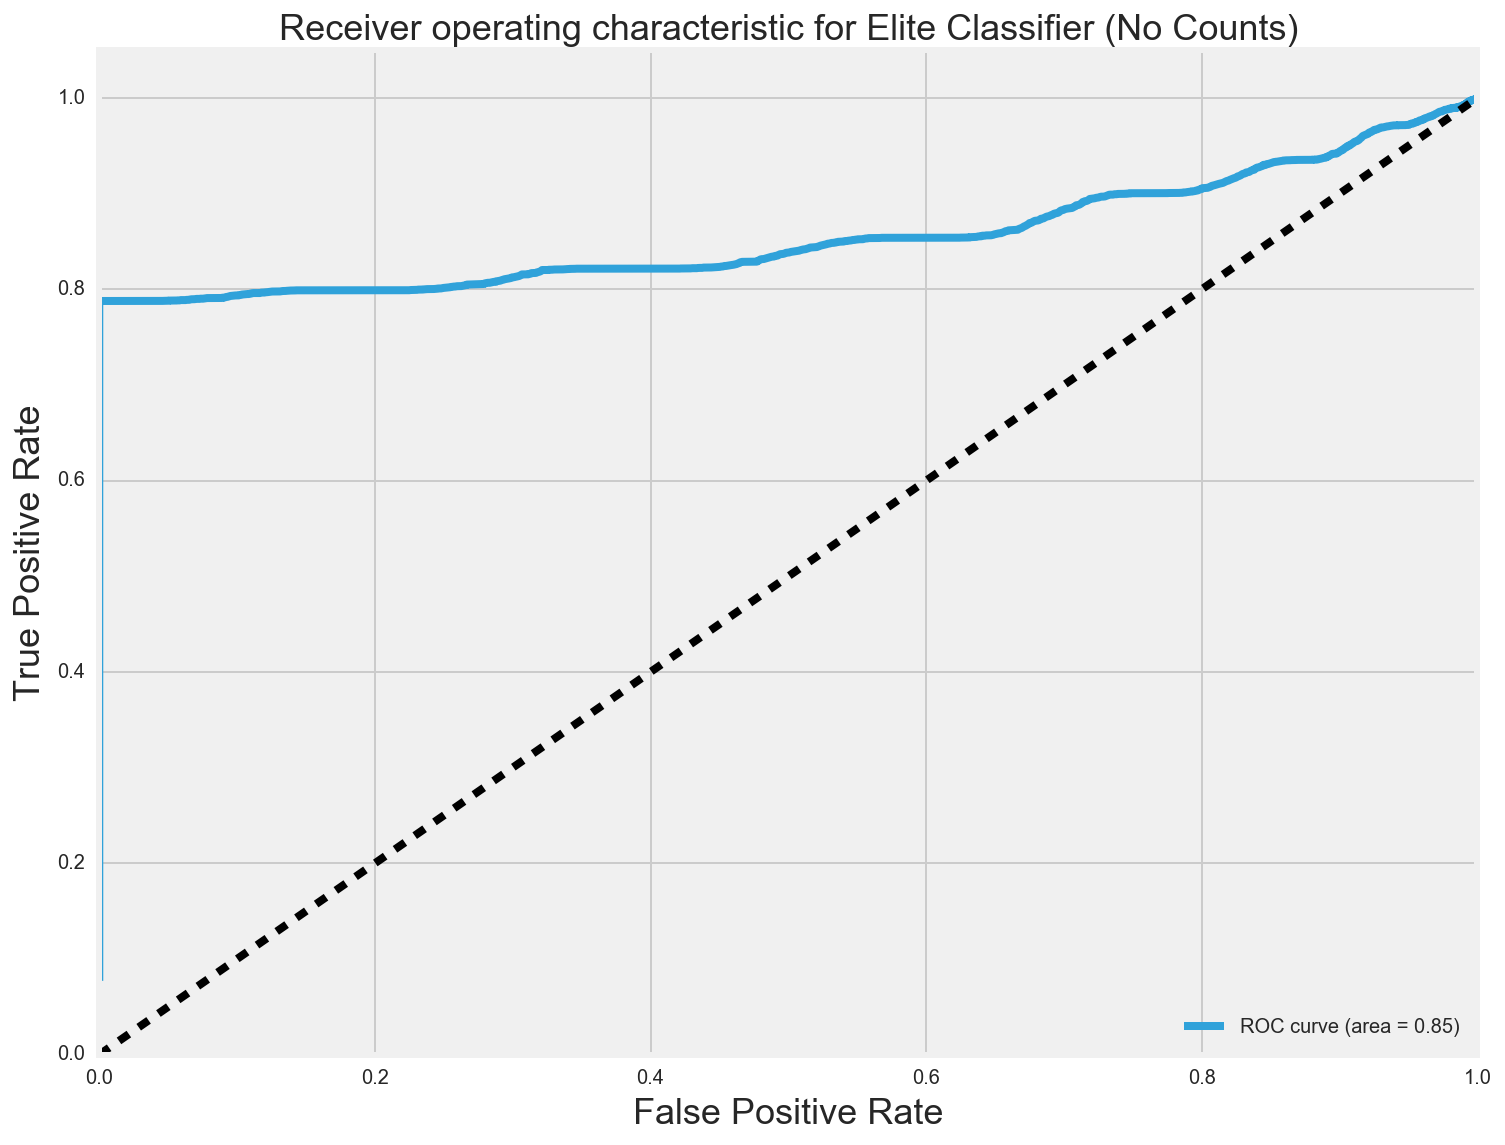

In [648]:
# Ridge No Counts ROC Curve
no_counts_y_score = logreg_ridge_count.decision_function(Xn_no_counts_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_elite_test_nc, no_counts_y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (is_vegas)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Elite Classifier (No Counts)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Give a brief write-up of your findings.

It looks like review count and fans are the primary positive identifications for whether a user is elite or not in my metric. Elite status is also negatively correlated with how long they've been a member. This is probably due to the way that I defined 'Elite' because if a user signed up a long time ago and then became inactive, they are unlikely to be consider elite under my metric.

We also see that even without the count columns will are still able to get pretty good predictions on whether or not a user is elite from just the stars of the users and the years they've been a member.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Extend the `LinearRegrssion` class to include the following: 

- Calculate confidence intervals at X% on the $\beta$ coefficients and predicted y value when the model is not regularized. Here is a good overview of calculating confidence intervals: http://imgur.com/a/O1ZFk



- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]

Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

In [ ]:
class LinearRegression(object):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coefs_ = None 
    
    def fit_intercept_fn(self, X):
        if self.fit_intercept:
            intercept = np.ones((X.shape[0], 1))
            X_int = np.hstack((intercept, X))
            return X_int 
        return X 
    
    def fit(self, X, y):
        self.X = self.fit_intercept_fn(X)
        self.y = y 
        
        ## matrix multiplication magic 
        coefs = np.linalg.inv(self.X.T.dot(self.X))
        coefs = coefs.dot(self.X.T).dot(self.y)
        
        if self.fit_intercept:
            self.coefs_ = coefs[1:]
            self.intercept_ = coefs[0]
        else:
            self.coefs_ = coefs 
        
        self.coefs = coefs
            
    def predict(self, X=None):
        if not self.coefs_:
            raise Exception('Fit your data before using predict method')
        
        if X is None: 
            X = self.X 
        else:
            X = self.fit_intercept_fn(X)
            
        return X.dot(self.coefs)
    
    def score(self, X=None, y=None):
        """
        calculate rsquared 
        """
        if X is None:
            y = self.y 
            y_hat = self.predict()
        else:
            y_hat = self.predict(X)
        
        ## residuals 
        ssr = np.sum((y - y_hat) ** 2)
        self.mse = np.mean((y - y_hat) ** 2)
        
        ## mean residuals 
        sst = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ssr / sst 
        return r2

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the `NearestNeighbor` class such that the predict method doesn't use a `for loop`


In [490]:
class NearestNeighbor(object):
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y=None):
        self.X_tr = X 
        self.y_tr = y
    
    def predict(self, X, y=None):
        ## number of data points in test data 
        n_test = X.shape[0]
        
        ## distances ## 
        self.nn_dist = np.zeros((n_test, self.n_neighbors))

        if type(self.y_tr) != type(None): 
            y_pred = np.zeros(n_test)
            
        ## loop over all the test rows 
        for i in range(n_test):
            ## l2 distance 
            distances = np.sum(np.square(self.X_tr - X[i]), axis=1)
            nns = distances.argsort()[:self.n_neighbors]
            self.nn_dist[i] = nns
            
            if type(self.y_tr) != type(None): 
                y_pred[i] = sp.stats.mstats.mode(self.y_tr[nns])[0]
        
        if type(self.y_tr) != type(None): 
            if type(y)  != type(None):
                self.acc = np.sum(y_pred == y) / n_test
            return y_pred
    
    def predict2(self, X, y=None):
        distances = sp.spatial.distance.cdist(X, self.X_tr)
        self.nn_dist = distances.argsort(axis=1)[:,:self.n_neighbors]
        
        if type(self.y_tr) != type(None):
            y_val = self.y_tr[self.nn_dist]
            y_pred = np.array(sp.stats.mstats.mode(y_val, axis=1)[0]).reshape(-1)
            
            if type(y)  != type(None):
                self.acc = np.sum(y_pred == y) / n_test
            return y_pred

In [496]:
X_tr = np.random.rand(25,20)
X = np.random.rand(23,20)
y = np.random.randint(2, size=25)

In [492]:
nn = NearestNeighbor(5)

In [493]:
nn.fit(X_tr, y)

In [499]:
nn.predict(X) == nn.predict2(X)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 8. Implement `LogisticRegression` that fits the model using Stochastic Gradient Descent. 

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 9. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test when you apply it on the raw dataset vs. compressed dataset from SVD. 

In [657]:
# Get Data
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

NameError: name 'custom_data_home' is not defined

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [ ]:
def close_pair(x, arr1, arr2):
    dist = [arr1[0], arr2[0], abs(arr1[0] + arr2[0] - x)]
    for num1 in arr1:
        for num2 in arr2:
            test_dist = abs(num1 + num2 - x)
            if test_dist < dist[2]:
                dist = [num1, num2, test_dist]
    return dist
                

In [1]:
from __future__ import division

def binary_search(val, list1):
    n = int(len(list1)/2)
    while True:
        if list1:
            print n
            if val == list1[n]:
                return n
            elif n == 0  or n == len(list1) - 1:
                return False
            elif val > list1[n]:
                n += int(len(list1[n:])/2)
            elif val <= list1[n]:
                n -= int(len(list1[n:])/2)
        else:
            return False
        
        
        
    

In [2]:
binary_search(19, [1,2,3,4,5,6,7,17,17,18,21])

5
8
9
10


False

In [111]:
def merge_sort(list1, list2):
    merge_list = []
    while list1 or list2:
        if list1 and list2:
            if list1[0] <= list2[0]:
                merge_list.append(list1[0])
                list1 = list1[1:]
            elif list1[0] > list2[0]:
                merge_list.append(list2[0])
                list2 = list2[1:]
        elif list1:
            merge_list.append(list1[0])
            list1 = list1[1:]
        elif list2:
            merge_list.append(list2[0])
            list2 = list2[1:]
    return merge_list

[1, 2, 2, 2, 2, 3, 3, 5, 6, 7, 8, 10, 12, 25, 27, 27, 27, 100, 100, 103]

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance?


- The bias is ability of your model make predictions given ideal information
- Variance is how unpredictable a model is given the data it's trained on
- It's a useful framework because it helps you understand why your model is performing poorly and what to do about it (i.e how to tune in order to fix the issue)
- Variance is detectable if your predictions on the same data vary widely dependent on your training information


- Explain why cross-validation is important.

- cross validation is important because you want to evaluate your model on 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes?
- regularization is the ability to decrease the number to features in your model


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- linear regression: LMS
- logisitc regression: exponeniated


- Can you give examples of feature engineering on datasets you have worked with? 